In [ ]:

#from autogluon import TabularPrediction as task
#import autosklearn
from tpot import TPOTClassifier
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
# from deap import creator
from sklearn.model_selection import cross_val_score


In [ ]:
!pip install tpot

     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 163kB 22.1MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=257fd81f892bf7770a02f9bc255b113bb92f53dbe41c82f0df9615bc112595d0
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


In [ ]:
# def get_pool_sklearn(pool_):
#   out = []
#   for pipeline_str in list(pool_):  
#     optimized_pipeline = creator.Individual.from_string(pipeline_str, tpot._pset) # deap object
#     fitted_pipeline = tpot._toolbox.compile(expr=optimized_pipeline ) # scikit-learn pipeline object
#     fitted_pipeline.fit(X_train, y_train)
#     print(pipeline_str, 'score', roc_auc_score(y_test, fitted_pipeline.predict(X_test)))
#     out.append(fitted_pipeline)
#   return out

def fit_pool(X_train, X_test, y_train, y_test, max_time):
  tpot = TPOTClassifier(verbosity=3, random_state=42, n_jobs=-1, max_time_mins=max_time)
  tpot.fit(X_train, y_train)
  print(tpot.score(X_test, y_test))

  df_candidates = pd.DataFrame(tpot.evaluated_individuals_).transpose()
  best_candidates = df_candidates.sort_values('internal_cv_score', ascending=False).head(10)
  out = []
  for pipeline_str in list(dict(best_candidates.transpose())):  
    optimized_pipeline = creator.Individual.from_string(pipeline_str, tpot._pset) # deap object
    fitted_pipeline = tpot._toolbox.compile(expr=optimized_pipeline ) # scikit-learn pipeline object
    fitted_pipeline.fit(X_train, y_train)
    print(pipeline_str, 'score', roc_auc_score(y_test, fitted_pipeline.predict(X_test)))
    out.append(fitted_pipeline)
  return out

def plot_contour_pool(pool_, data):
  # Plotting decision regions
  x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
  y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                      np.arange(y_min, y_max, 0.01))
  colors_ = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink', 'cyan', 'black', 'grey', 'lime']
  i = 0
  sns.scatterplot(data[:,0], data[:, 1], hue=y_train)
  for clf in pool_:
      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      Z = Z.reshape(xx.shape)
      plt.contour(xx, yy, Z, alpha=0.5, colors=colors_[i], linewidths=1.1, linestyles='solid' )
      i += 1
  plt.show()

# mesurer si les prédictions sont significativement différentes ou non
def cohen_score(clf1, clf2, data):
  y_clf1 = clf1.predict(data)
  y_clf2 = clf2.predict(data)
  n_obs = data.shape[0]
  # cobs observed agreement
  cobs = (y_clf1 == y_clf2).sum() / n_obs
  # cexp agreement by chance 
  cexp = (y_clf1.mean() * y_clf2.mean()) + ((1 - y_clf1.mean()) * (1 - y_clf2.mean()))
  k = (cobs - cexp)/(1 - cexp)
  return k



2D half moons

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, shuffle=True, noise=0.3, random_state=1)
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.3,
                                     stratify=y, random_state=1)

MAX_TIME_MOONS = 1
pool = fit_pool(X_train, X_test, y_train, y_test, max_time=MAX_TIME_MOONS)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


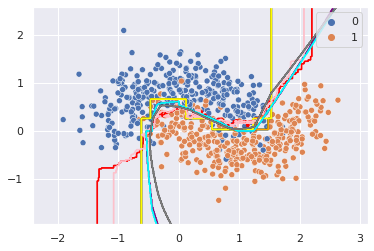

In [ ]:
import seaborn as sns
sns.set_context("paper")
sns.set_theme()

plot_contour_pool(pool, X_train)


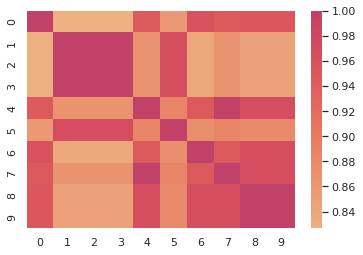

In [ ]:
agreement_matrix = np.array([[cohen_score(pool[i], pool[j], X_test) for i in range(len(pool))] for j in range(len(pool))])
sns.heatmap(data=agreement_matrix, center=1.0, cmap="flare")

# German Credit dataset


In [ ]:
from sklearn.preprocessing import StandardScaler
data = fetch_openml('credit-g', as_frame=True)
X = data.frame
X_full = X.copy()
y = (X['class'] == "good").astype('int')
del X['class']
discrete = X.select_dtypes(include=['category'])
discrete_ohe = pd.get_dummies(X, columns=discrete.columns)
X = pd.concat((X, discrete_ohe), axis=1)
for c in discrete.columns:
  del X[c]

# split into train/test set
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.3,
                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)
print(X_train.shape, y_train.mean())

(700, 70) 0.7


32 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 '(slice(None, None, None), 0)' is an invalid key.
_pre_test decorator: _random_mutation_operator: num_test=0 feature_names must be unique.
_pre_test decorator: _random_mutation_operator: num_test=1 feature_names must be unique.
_pre_test decorator: _random_mutation_operator: num_test=0 feature_names must be unique.
_pre_test decorator: _random_mutation_operator: num_test=1 feature_names must be unique.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


KNeighborsClassifier(MLPClassifier(input_matrix, MLPClassifier__alpha=0.0001, MLPClassifier__learning_rate_init=0.001), KNeighborsClassifier__n_neighbors=15, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=distance) score 0.6190476190476191
RandomForestClassifier(GaussianNB(MinMaxScaler(MinMaxScaler(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=26, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)))), RandomForestClassifier__bootstrap=True, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_features=0.05, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=11, RandomForestClassifier__n_estimators=100) score 0.6396825396825396
RandomForestClassifier(GaussianNB(MinMaxScaler(MinMaxScaler(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=26, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)))), RandomForestClassifier__bootstrap=True, RandomForestClassifier__

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


KNeighborsClassifier(MLPClassifier(input_matrix, MLPClassifier__alpha=0.0001, MLPClassifier__learning_rate_init=0.001), KNeighborsClassifier__n_neighbors=10, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=distance) score 0.6436507936507936
BernoulliNB(LinearSVC(input_matrix, LinearSVC__C=0.001, LinearSVC__dual=False, LinearSVC__loss=squared_hinge, LinearSVC__penalty=l2, LinearSVC__tol=0.1), BernoulliNB__alpha=0.01, BernoulliNB__fit_prior=True) score 0.6666666666666667
CPU times: user 2min 24s, sys: 48 s, total: 3min 12s
Wall time: 20min 26s


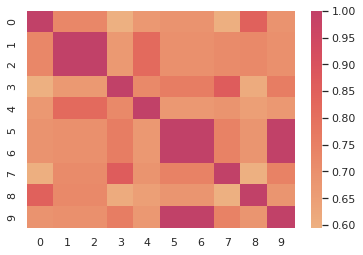

In [ ]:
%%time
MAX_TIME_ADULT = 20
pool = fit_pool(X_train, X_test, y_train, y_test, max_time=MAX_TIME_ADULT)
agreement_matrix = np.array([[cohen_score(pool[i], pool[j], X_test) for i in range(len(pool))] for j in range(len(pool))])
sns.heatmap(data=agreement_matrix, center=1.0, cmap="flare")

ValueError: ignored

# Initialisations différentes du meme algo


[0.7366666666666667, 0.7266666666666667, 0.7266666666666667, 0.7266666666666667, 0.7233333333333334, 0.7333333333333333, 0.7333333333333333, 0.73, 0.73, 0.7266666666666667]


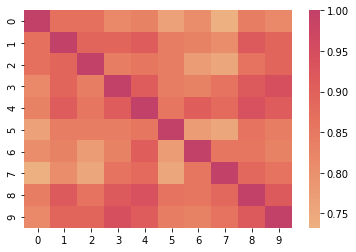

In [ ]:
# le dataset doit etre en memoire
from sklearn.ensemble import RandomForestClassifier
pool = [RandomForestClassifier(n_estimators=200, max_depth=5, random_state=i).fit(X_train, y_train) for i in range(10)]
print([(cc.predict(X_test) == y_test).mean() for cc in pool])
agreement_matrix = np.array([[cohen_score(pool[i], pool[j], X_test) for i in range(len(pool))] for j in range(len(pool))])
sns.heatmap(data=agreement_matrix, center=1.0, cmap="flare")